In [4]:
import sys
import os

repo_root = "/home/druban/gpu_tests/ot-algorithm-comparison"
sys.path.insert(0, str(repo_root))

os.environ["CUDA_VISIBLE_DEVICES"] = "3"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.0"

In [5]:
import jax
import ot
from jax import numpy as jnp
import logging
from uot.problems.generators.gaussian_mixture_generator import GaussianMixtureGenerator
from uot.solvers.base_solver import BaseSolver
from uot.utils.costs import cost_euclid_squared
from matplotlib import pyplot as plt
from uot.solvers.pdlp import PDLPSolver
from uot.solvers.sinkhorn import SinkhornTwoMarginalSolver
from uot.solvers.gradient_ascent import GradientAscentTwoMarginalSolver
from uot.solvers.ott_sinkhorn import OTTSinkhornSolver
from uot.experiments.experiment import Experiment
from uot.experiments.measurement import measure_time_and_precision, measure_pushforward
from uot.solvers.pdlp_barycenter import PDLPBarycenterSolver
from uot.solvers.pot_barycenter import POTSinkhornBarycenterSolver
from uot.problems.problem_generator import ProblemGenerator

jax.config.update("jax_enable_x64", True)

2025-07-23 07:29:06.211128: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753270146.227624 2812016 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753270146.232789 2812016 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753270146.245845 2812016 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753270146.245859 2812016 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753270146.245861 2812016 computation_placer.cc:177] computation placer alr

In [6]:
import numpy as np

def gm_barycenter_1d(
    margs,
    marg_weights: jnp.ndarray | None = None,   # (n_marginals,), optional
):
    means = [margs[0].means[0], margs[1].means[0]] if margs[0].means.shape == (1, 1) else jnp.array([
        margs[0].means, margs[1].means
    ]).reshape(2, 2)
    sigmas = [
        jnp.sqrt(margs[0].covs[0][0]), jnp.sqrt(margs[1].covs[0][0])
    ] if margs[0].covs.shape == (1, 1, 1) else [
        jnp.sqrt(margs[0].covs), jnp.sqrt(margs[1].covs)
    ]
    mix_weights = [margs[0].comp_weights, margs[1].comp_weights]

    means   = jnp.asarray(means,  dtype=float)
    sigmas  = jnp.asarray(sigmas, dtype=float)
    weights = jnp.asarray(mix_weights, dtype=float)
    marg_weights = jnp.asarray(marg_weights, dtype=float)
    marg_weights = marg_weights / marg_weights.sum()

    if means.shape != sigmas.shape or means.shape != weights.shape:
        raise ValueError("means, sigmas, mix_weights must share the same shape")

    # barycenter mixture weights  π̄_j
    bar_mix = (marg_weights[:, None] * weights).sum(axis=0)
    bar_mix = bar_mix / bar_mix.sum()        # ensure ∑π̄ = 1

    # component‑wise Gaussian barycenters
    bar_means  = (marg_weights[:, None] * means).sum(axis=0)
    bar_sigmas = (marg_weights[:, None] * sigmas).sum(axis=0)

    return bar_means, bar_sigmas, bar_mix

In [7]:
from typing import Any
import time

def monge_bary()

def _wait_jax_finish(result: dict[str, Any]) -> dict[str, Any]:
    """Block until all JAX arrays in `result` are ready."""
    return jax.tree_util.tree_map(
        lambda x: x.block_until_ready() if isinstance(x, jax.Array) else x,
        result
    )

_vec = lambda x: jnp.asarray(x).ravel()

# ------------------------------------------------------------
def _bary_proj(pi, y, a):              # T_i(x_k) = Σ_j π_kj y_j / a_k
    return (pi @ y) / (a + 1e-12)

# analytic Gaussian barycenter PDF (1‑D)
def gm_pdf(x, means, sigmas, weights=None):
    means  = jnp.asarray(means,  dtype=float)
    sigmas = jnp.asarray(sigmas, dtype=float)
    if weights is None:
        weights = jnp.ones_like(means) / means.size
    else:
        weights = jnp.asarray(weights, dtype=float)
        weights = weights / weights.sum()

    x = jnp.asarray(x, dtype=float)[..., None]          # broadcast over comps
    z = (x - means) / sigmas
    comp_pdf = jnp.exp(-0.5 * z**2) / (sigmas * jnp.sqrt(2.0 * jnp.pi))
    return jnp.sum(weights * comp_pdf, axis=-1)

def _interp_scalar(x, grid, u):
    grid, u = _vec(grid), _vec(u)
    i  = jnp.clip(jnp.searchsorted(grid, x) - 1, 0, grid.size - 2)
    x0, x1 = grid[i], grid[i + 1]
    t  = (x - x0) / (x1 - x0 + 1e-12)
    return (1 - t) * u[i] + t * u[i + 1]

# ------------------------------------------------------------
def bary_bias(
    margs,           # [(μ_x, μ_w), …]
    plans,           # [π_1, …]      same order
    m_star, sigma_star, comp_weights
):
    def _single(marg, pi):
        mu_x, mu_w = map(_vec, marg)
        # barycentric map on *this* marginal’s support
        T = _bary_proj(pi, mu_x, mu_w)          # shape (n_mu,)

        # analytic ν★ evaluated at those T‑locations
        nu_w = gm_pdf(T, m_star, sigma_star, comp_weights)
        nu_w = nu_w / nu_w.sum()                # normalise to 1

        # Wasserstein‑2 between (T, μ_w) and (T, ν_w)
        C  = (T[:, None] - T[None, :]) ** 2
        w2 = jnp.sqrt(ot.emd2(mu_w, nu_w, C))

        # optional pointwise MSE on those same points
        mse = jnp.sum((mu_w - nu_w) ** 2)
        return w2, mse

    w2s, mses = zip(*[_single(m, p) for m, p in zip(margs, plans)])
    return jnp.array(mses).mean(), jnp.array(w2s).mean()

# ────────────── Monge‑map branch (interp + AD) ──────────────────────
def monge_bias(
    margs,            # [(μ_x, μ_w), …]       — one per marginal
    u_list,           # [u_vals_1, u_vals_2, …]  same order as margs
    m_star,           # mean of analytic barycenter
    sigma_star,       # std‑dev of analytic barycenter
    comp_weights
):
    """
    For each marginal μ_i, computes the Monge map T_i = id - ∇u_i
    and compares the discrete push‑forward T_i♯μ_i against the analytic
    Gaussian barycenter ν★ **on the very same support T_i**.

    Returns per‑marginal W₂ and MSE, plus their averages.
    """

    # --- inner helper, JIT‑vectorisable -----------------------------
    def _single_bias(marg, u_vals):
        mu_x, mu_w = map(_vec, marg)      # support & weights of μ_i

        # 1.  Monge map via gradient of the potential
        grad_fn = jax.grad(lambda z: _interp_scalar(z, mu_x, u_vals))
        grad    = jax.vmap(grad_fn)(mu_x)
        T       = mu_x - grad              # push‑forward locations

        # 2.  Build analytic ν★ on exactly those T‑points
        nu_w = gm_pdf(T, m_star, sigma_star, comp_weights)
        nu_w = nu_w / nu_w.sum()           # discrete prob. weights

        # 3.  Wasserstein‑2 distance (same support ⇒ simple cost)
        C  = (T[:, None] - T[None, :])**2  # (n, n) cost matrix
        w2 = jnp.sqrt(ot.emd2(mu_w, nu_w, C))

        # 4.  Point‑wise mean‑squared error of weights
        mse = jnp.sum((mu_w - nu_w)**2)

        return w2, mse

    # Vectorised over all marginals
    w2s, mses = zip(*[_single_bias(m, u) for m, u in zip(margs, u_list)])
    return jnp.array(mses).mean(), jnp.array(w2s).mean()

# ────────────── public entry point ──────────────────────────────────

def direct_bias(bary, grid, m_star, sigma_star, comp_weights):
    nu_star = gm_pdf(grid, m_star, sigma_star, comp_weights)
    nu_star /= nu_star.sum()

    mse = jnp.sum((bary - nu_star) ** 2)

    C = (grid[:, None] - grid[None, :])**2
    w2 = jnp.sqrt(ot.emd2(bary / bary.sum(), nu_star, C))
    return mse, w2

def measure_barycenter(prob, solver, marginals, costs, **kwargs):
    instance = solver()
    start_time = time.perf_counter()
    res = instance.solve(marginals=marginals, costs=costs, **kwargs)
    # _wait_jax_finish(res)
    time_end = (time.perf_counter() - start_time) * 1000

    bary, plans, us = res["barycenter"], res["transport_plans"], res["vs_final"]
    margs = jnp.asarray([(m.to_discrete()[0].reshape(-1), m.to_discrete()[1]) for m in marginals])

    m_star, sigma_star, comp_weights = gm_barycenter_1d(marginals, prob._weights)

    bl2, bw2 = bary_bias(margs, plans, m_star, sigma_star, comp_weights)
    ml2, mw2 = monge_bias(margs, us, m_star, sigma_star, comp_weights)
    if not jnp.isnan(bary).any():
        dl2, dw2 = direct_bias(bary, margs[0][0], m_star, sigma_star, comp_weights)
    else:
        dl2, dw2 = jnp.nan, jnp.nan

    return dict(
        barycentric_l2_bias = bl2,
        barycentric_w2_bias = bw2,
        monge_l2_bias       = ml2,
        monge_w2_bias       = mw2,
        direct_l2_bias      = dl2,
        direct_w2_bias      = dw2,
        time                = time_end,
    )

In [8]:
import pandas as pd

def run_experiments_on_dataset(
    generator: ProblemGenerator,
    regs: list[float],
    solvers: list[BaseSolver],
    **kwargs,
):
    ## Gather metrics first
    records = []
    experiment = Experiment(
        name="Barycenter tests",
        solve_fn=measure_barycenter
    )
    for solver in solvers:
        for reg in regs:
            df = experiment.run_on_problems(
                problems=generator.generate_barycenter(),
                solver=solver,
                reg=reg,
                **kwargs,
            )

            records.append({
                'name': solver.__name__,
                'reg': reg,
                'avg_barycentric_l2_bias': df["barycentric_l2_bias"].mean(),
                'avg_barycentric_w2_bias': df["barycentric_w2_bias"].mean(),
                'avg_monge_l2_bias': df["monge_l2_bias"].mean(),
                'avg_monge_w2_bias': df["monge_w2_bias"].mean(),
                'avg_direct_l2_bias': df["direct_l2_bias"].mean(),
                'avg_direct_w2_bias': df["direct_w2_bias"].mean(),
            })

    df_result = pd.DataFrame(records)
    return df_result

    ## Plot the results

    # # 1️⃣  Average runtime vs reg
    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    #
    # fig.suptitle(generator._name)
    #
    # for name, sub in df_result.groupby("name"):
    #     ax1.plot(sub["reg"], sub["avg_time"], marker="o", label=name)
    # ax1.set_xscale("log")
    # ax1.set_yscale("log")
    # ax1.set_xlabel("Regularisation $\\varepsilon$")
    # ax1.set_title("Avg. Runtime")        # <- common prefix
    # ax1.legend()
    #
    # # 2️⃣  Average cost‑error vs reg
    # for name, sub in df_result.groupby("name"):
    #     ax2.plot(sub["reg"], sub["avg_cost_err"], marker="o", label=name)
    # ax2.set_xscale("log")
    # ax2.set_yscale("log")
    # ax2.set_xlabel("Regularisation $\\varepsilon$")
    # ax2.set_title("Avg. Precision")      # <- same prefix
    # ax2.legend()

In [9]:
guassian_generator = GaussianMixtureGenerator(
    name="Gauss1D-256p",
    dim=1,
    num_marginals=2,
    num_components=1,
    n_points=256,
    num_datasets=10,
    weights=[0.5, 0.5],
    borders=[-6, 6],
    cost_fn=cost_euclid_squared,
    use_jax=False
)
df_results_256 = run_experiments_on_dataset(
    generator=guassian_generator,
    solvers=[PDLPBarycenterSolver, POTSinkhornBarycenterSolver],
    regs=[1e-2, 1e-1, 1.0, 10.0, 100.0],
    weights=[0.5, 0.5], maxiter=10000, tol=1e-6
)

[1.]
[1.]
[1.]
[1.]
2025-07-23 07:29:12,470 uot INFO: Starting PDLPBarycenterSolver with {'reg': 0.01, 'weights': [0.5, 0.5], 'maxiter': 10000, 'tol': 1e-06} on <BarycenterProblem[Gauss1D-256p] 256x256        with (<map object at 0x7fc4f81be7a0>)>
2025-07-23 07:29:31,009 uot INFO: Successfully finished PDLPBarycenterSolver with {'reg': 0.01, 'weights': [0.5, 0.5], 'maxiter': 10000, 'tol': 1e-06}
[1.]
[1.]
[1.]
[1.]
2025-07-23 07:29:31,013 uot INFO: Starting PDLPBarycenterSolver with {'reg': 0.01, 'weights': [0.5, 0.5], 'maxiter': 10000, 'tol': 1e-06} on <BarycenterProblem[Gauss1D-256p] 256x256        with (<map object at 0x7fc4d039ada0>)>
2025-07-23 07:29:45,589 uot INFO: Successfully finished PDLPBarycenterSolver with {'reg': 0.01, 'weights': [0.5, 0.5], 'maxiter': 10000, 'tol': 1e-06}
[1.]
[1.]
[1.]
[1.]
2025-07-23 07:29:45,593 uot INFO: Starting PDLPBarycenterSolver with {'reg': 0.01, 'weights': [0.5, 0.5], 'maxiter': 10000, 'tol': 1e-06} on <BarycenterProblem[Gauss1D-256p] 256x256 

/home/druban/miniconda3/envs/py311/lib/python3.11/site-packages/ot/lp/__init__.py:630: UserWarning: Problem infeasible. Check that a and b are in the simplex
  check_result(result_code)


2025-07-23 07:30:29,342 uot INFO: Successfully finished PDLPBarycenterSolver with {'reg': 0.01, 'weights': [0.5, 0.5], 'maxiter': 10000, 'tol': 1e-06}
[1.]
[1.]
[1.]
[1.]
2025-07-23 07:30:29,346 uot INFO: Starting PDLPBarycenterSolver with {'reg': 0.01, 'weights': [0.5, 0.5], 'maxiter': 10000, 'tol': 1e-06} on <BarycenterProblem[Gauss1D-256p] 256x256        with (<map object at 0x7fc4d039ada0>)>
2025-07-23 07:30:43,875 uot INFO: Successfully finished PDLPBarycenterSolver with {'reg': 0.01, 'weights': [0.5, 0.5], 'maxiter': 10000, 'tol': 1e-06}
[1.]
[1.]
[1.]
[1.]
2025-07-23 07:30:43,880 uot INFO: Starting PDLPBarycenterSolver with {'reg': 0.01, 'weights': [0.5, 0.5], 'maxiter': 10000, 'tol': 1e-06} on <BarycenterProblem[Gauss1D-256p] 256x256        with (<map object at 0x7fc7047ef4c0>)>
2025-07-23 07:30:53,374 uot INFO: Successfully finished PDLPBarycenterSolver with {'reg': 0.01, 'weights': [0.5, 0.5], 'maxiter': 10000, 'tol': 1e-06}
[1.]
[1.]
[1.]
[1.]
2025-07-23 07:30:53,378 uot INF

/home/druban/miniconda3/envs/py311/lib/python3.11/site-packages/ot/bregman/_barycenter.py:250: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
/home/druban/miniconda3/envs/py311/lib/python3.11/site-packages/ot/bregman/_sinkhorn.py:643: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn("Warning: numerical errors at iteration %d" % ii)


2025-07-23 07:39:57,650 uot INFO: Successfully finished POTSinkhornBarycenterSolver with {'reg': 0.01, 'weights': [0.5, 0.5], 'maxiter': 10000, 'tol': 1e-06}
[1.]
[1.]
[1.]
[1.]
2025-07-23 07:39:57,654 uot INFO: Starting POTSinkhornBarycenterSolver with {'reg': 0.01, 'weights': [0.5, 0.5], 'maxiter': 10000, 'tol': 1e-06} on <BarycenterProblem[Gauss1D-256p] 256x256        with (<map object at 0x7fc4d017a650>)>
2025-07-23 07:40:12,142 uot INFO: Successfully finished POTSinkhornBarycenterSolver with {'reg': 0.01, 'weights': [0.5, 0.5], 'maxiter': 10000, 'tol': 1e-06}
[1.]
[1.]
[1.]
[1.]
2025-07-23 07:40:12,145 uot INFO: Starting POTSinkhornBarycenterSolver with {'reg': 0.01, 'weights': [0.5, 0.5], 'maxiter': 10000, 'tol': 1e-06} on <BarycenterProblem[Gauss1D-256p] 256x256        with (<map object at 0x7fc4d01798a0>)>
2025-07-23 07:40:26,363 uot INFO: Successfully finished POTSinkhornBarycenterSolver with {'reg': 0.01, 'weights': [0.5, 0.5], 'maxiter': 10000, 'tol': 1e-06}
[1.]
[1.]
[1.]
[

In [10]:
guassian_generator = GaussianMixtureGenerator(
    name="Gauss1D-512p",
    dim=1,
    num_marginals=2,
    num_components=1,
    n_points=512,
    num_datasets=10,
    weights=[0.5, 0.5],
    borders=[-6, 6],
    cost_fn=cost_euclid_squared,
    use_jax=False
)
df_results_512 = run_experiments_on_dataset(
    generator=guassian_generator,
    solvers=[PDLPBarycenterSolver, POTSinkhornBarycenterSolver],
    regs=[1e-2, 1e-1, 1.0, 10.0, 100.0],
    weights=[0.5, 0.5], maxiter=10000, tol=1e-6
)

[1.]
[1.]
[1.]
[1.]
2025-07-23 07:42:45,628 uot INFO: Starting PDLPBarycenterSolver with {'reg': 0.01, 'weights': [0.5, 0.5], 'maxiter': 10000, 'tol': 1e-06} on <BarycenterProblem[Gauss1D-512p] 512x512        with (<map object at 0x7fc4d01ce230>)>
2025-07-23 07:43:04,345 uot INFO: Successfully finished PDLPBarycenterSolver with {'reg': 0.01, 'weights': [0.5, 0.5], 'maxiter': 10000, 'tol': 1e-06}
[1.]
[1.]
[1.]
[1.]
2025-07-23 07:43:04,348 uot INFO: Starting PDLPBarycenterSolver with {'reg': 0.01, 'weights': [0.5, 0.5], 'maxiter': 10000, 'tol': 1e-06} on <BarycenterProblem[Gauss1D-512p] 512x512        with (<map object at 0x7fc4ac1cf850>)>


/home/druban/miniconda3/envs/py311/lib/python3.11/site-packages/ot/lp/__init__.py:630: UserWarning: Problem infeasible. Check that a and b are in the simplex
  check_result(result_code)


2025-07-23 07:43:19,464 uot INFO: Successfully finished PDLPBarycenterSolver with {'reg': 0.01, 'weights': [0.5, 0.5], 'maxiter': 10000, 'tol': 1e-06}
[1.]
[1.]
[1.]
[1.]
2025-07-23 07:43:19,467 uot INFO: Starting PDLPBarycenterSolver with {'reg': 0.01, 'weights': [0.5, 0.5], 'maxiter': 10000, 'tol': 1e-06} on <BarycenterProblem[Gauss1D-512p] 512x512        with (<map object at 0x7fc4ac1bae60>)>
2025-07-23 07:43:34,630 uot INFO: Successfully finished PDLPBarycenterSolver with {'reg': 0.01, 'weights': [0.5, 0.5], 'maxiter': 10000, 'tol': 1e-06}
[1.]
[1.]
[1.]
[1.]
2025-07-23 07:43:34,634 uot INFO: Starting PDLPBarycenterSolver with {'reg': 0.01, 'weights': [0.5, 0.5], 'maxiter': 10000, 'tol': 1e-06} on <BarycenterProblem[Gauss1D-512p] 512x512        with (<map object at 0x7fc4d0236890>)>
2025-07-23 07:43:49,756 uot INFO: Successfully finished PDLPBarycenterSolver with {'reg': 0.01, 'weights': [0.5, 0.5], 'maxiter': 10000, 'tol': 1e-06}
[1.]
[1.]
[1.]
[1.]
2025-07-23 07:43:49,759 uot INF

/home/druban/miniconda3/envs/py311/lib/python3.11/site-packages/ot/bregman/_barycenter.py:250: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
/home/druban/miniconda3/envs/py311/lib/python3.11/site-packages/ot/bregman/_sinkhorn.py:643: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn("Warning: numerical errors at iteration %d" % ii)


2025-07-23 07:54:18,455 uot INFO: Successfully finished POTSinkhornBarycenterSolver with {'reg': 0.01, 'weights': [0.5, 0.5], 'maxiter': 10000, 'tol': 1e-06}
[1.]
[1.]
[1.]
[1.]
2025-07-23 07:54:18,458 uot INFO: Starting POTSinkhornBarycenterSolver with {'reg': 0.01, 'weights': [0.5, 0.5], 'maxiter': 10000, 'tol': 1e-06} on <BarycenterProblem[Gauss1D-512p] 512x512        with (<map object at 0x7fc48c2c3340>)>
2025-07-23 07:54:32,825 uot INFO: Successfully finished POTSinkhornBarycenterSolver with {'reg': 0.01, 'weights': [0.5, 0.5], 'maxiter': 10000, 'tol': 1e-06}
[1.]
[1.]
[1.]
[1.]
2025-07-23 07:54:32,829 uot INFO: Starting POTSinkhornBarycenterSolver with {'reg': 0.01, 'weights': [0.5, 0.5], 'maxiter': 10000, 'tol': 1e-06} on <BarycenterProblem[Gauss1D-512p] 512x512        with (<map object at 0x7fc48c2c0d30>)>
2025-07-23 07:54:47,192 uot INFO: Successfully finished POTSinkhornBarycenterSolver with {'reg': 0.01, 'weights': [0.5, 0.5], 'maxiter': 10000, 'tol': 1e-06}
[1.]
[1.]
[1.]
[

In [ ]:
problems = gau

In [15]:
guassian_generator = GaussianMixtureGenerator(
    name="Gauss1D-1024p",
    dim=1,
    num_marginals=2,
    num_components=1,
    n_points=1024,
    num_datasets=10,
    weights=[0.5, 0.5],
    borders=[-6, 6],
    cost_fn=cost_euclid_squared,
    use_jax=False
)
df_results_1024 = run_experiments_on_dataset(
    generator=guassian_generator,
    solvers=[PDLPBarycenterSolver, POTSinkhornBarycenterSolver],
    regs=[1e-2, 1e-1, 1.0, 10.0, 100.0],
    weights=[0.5, 0.5], maxiter=10000, tol=1e-6
)

[1.]
[1.]
[1.]
[1.]
2025-07-23 07:59:43,213 uot INFO: Starting PDLPBarycenterSolver with {'reg': 0.01, 'weights': [0.5, 0.5], 'maxiter': 10000, 'tol': 1e-06} on <BarycenterProblem[Gauss1D-1024p] 1024x1024        with (<map object at 0x7fc4d03d1a50>)>
2025-07-23 08:00:04,045 uot INFO: Successfully finished PDLPBarycenterSolver with {'reg': 0.01, 'weights': [0.5, 0.5], 'maxiter': 10000, 'tol': 1e-06}
[1.]
[1.]
[1.]
[1.]
2025-07-23 08:00:04,050 uot INFO: Starting PDLPBarycenterSolver with {'reg': 0.01, 'weights': [0.5, 0.5], 'maxiter': 10000, 'tol': 1e-06} on <BarycenterProblem[Gauss1D-1024p] 1024x1024        with (<map object at 0x7fc48c14a8f0>)>


/home/druban/miniconda3/envs/py311/lib/python3.11/site-packages/ot/lp/__init__.py:630: UserWarning: Problem infeasible. Check that a and b are in the simplex
  check_result(result_code)


2025-07-23 08:00:20,724 uot INFO: Successfully finished PDLPBarycenterSolver with {'reg': 0.01, 'weights': [0.5, 0.5], 'maxiter': 10000, 'tol': 1e-06}
[1.]
[1.]
[1.]
[1.]
2025-07-23 08:00:20,730 uot INFO: Starting PDLPBarycenterSolver with {'reg': 0.01, 'weights': [0.5, 0.5], 'maxiter': 10000, 'tol': 1e-06} on <BarycenterProblem[Gauss1D-1024p] 1024x1024        with (<map object at 0x7fc46c24fca0>)>
2025-07-23 08:00:37,364 uot INFO: Successfully finished PDLPBarycenterSolver with {'reg': 0.01, 'weights': [0.5, 0.5], 'maxiter': 10000, 'tol': 1e-06}
[1.]
[1.]
[1.]
[1.]
2025-07-23 08:00:37,369 uot INFO: Starting PDLPBarycenterSolver with {'reg': 0.01, 'weights': [0.5, 0.5], 'maxiter': 10000, 'tol': 1e-06} on <BarycenterProblem[Gauss1D-1024p] 1024x1024        with (<map object at 0x7fc48c14a8f0>)>
2025-07-23 08:00:54,074 uot INFO: Successfully finished PDLPBarycenterSolver with {'reg': 0.01, 'weights': [0.5, 0.5], 'maxiter': 10000, 'tol': 1e-06}
[1.]
[1.]
[1.]
[1.]
2025-07-23 08:00:54,078 u

/home/druban/miniconda3/envs/py311/lib/python3.11/site-packages/ot/bregman/_barycenter.py:250: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
/home/druban/miniconda3/envs/py311/lib/python3.11/site-packages/ot/bregman/_sinkhorn.py:643: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn("Warning: numerical errors at iteration %d" % ii)


2025-07-23 08:13:09,735 uot INFO: Successfully finished POTSinkhornBarycenterSolver with {'reg': 0.01, 'weights': [0.5, 0.5], 'maxiter': 10000, 'tol': 1e-06}
[1.]
[1.]
[1.]
[1.]
2025-07-23 08:13:09,739 uot INFO: Starting POTSinkhornBarycenterSolver with {'reg': 0.01, 'weights': [0.5, 0.5], 'maxiter': 10000, 'tol': 1e-06} on <BarycenterProblem[Gauss1D-1024p] 1024x1024        with (<map object at 0x7fc48c14a8f0>)>
2025-07-23 08:13:24,585 uot INFO: Successfully finished POTSinkhornBarycenterSolver with {'reg': 0.01, 'weights': [0.5, 0.5], 'maxiter': 10000, 'tol': 1e-06}
[1.]
[1.]
[1.]
[1.]
2025-07-23 08:13:24,590 uot INFO: Starting POTSinkhornBarycenterSolver with {'reg': 0.01, 'weights': [0.5, 0.5], 'maxiter': 10000, 'tol': 1e-06} on <BarycenterProblem[Gauss1D-1024p] 1024x1024        with (<map object at 0x7fc46c10f6a0>)>
2025-07-23 08:13:39,743 uot INFO: Successfully finished POTSinkhornBarycenterSolver with {'reg': 0.01, 'weights': [0.5, 0.5], 'maxiter': 10000, 'tol': 1e-06}
[1.]
[1.]


In [11]:
df_results_256

,name,reg,avg_barycentric_l2_bias,avg_barycentric_w2_bias,avg_monge_l2_bias,avg_monge_w2_bias,avg_direct_l2_bias,avg_direct_w2_bias
0,PDLPBarycenterSolver,0.01,0.008443,37.849866,0.000024,9.039899e-02,0.000010,0.028475
1,PDLPBarycenterSolver,0.10,0.009391,3474.618463,0.000024,8.934391e-02,0.000014,0.028099
2,PDLPBarycenterSolver,1.00,0.008173,4202.948284,0.000146,1.371520e-01,0.000014,0.030904
3,PDLPBarycenterSolver,10.00,0.009737,219.549687,0.000514,8.865694e-02,0.000005,0.009636
4,PDLPBarycenterSolver,100.00,0.006726,510.528393,0.000061,1.232278e-01,0.000005,0.029824
5,POTSinkhornBarycenterSolver,0.01,0.006260,187.786269,0.011797,1.604216e+00,NaN,NaN
6,POTSinkhornBarycenterSolver,0.10,0.016033,3553.541440,0.035723,9.840129e+116,0.000042,0.044280
7,POTSinkhornBarycenterSolver,1.00,0.006719,219.411356,0.005499,1.706471e+07,0.000520,0.200963
8,POTSinkhornBarycenterSolver,10.00,0.007036,2549.807356,0.009419,8.553242e-01,0.005761,1.156743
9,POTSinkhornBarycenterSolver,100.00,0.004140,3258.569797,0.009710,9.717631e-01,0.005841,2.276189


In [12]:
df_results_512

,name,reg,avg_barycentric_l2_bias,avg_barycentric_w2_bias,avg_monge_l2_bias,avg_monge_w2_bias,avg_direct_l2_bias,avg_direct_w2_bias
0,PDLPBarycenterSolver,0.01,0.004244,30.731275,0.000011,8.292036e-02,0.000005,0.002545
1,PDLPBarycenterSolver,0.10,0.004683,2455.954104,0.000013,8.351382e-02,0.000003,0.026973
2,PDLPBarycenterSolver,1.00,0.004131,3065.992032,0.000076,1.389359e-01,0.000007,0.029901
3,PDLPBarycenterSolver,10.00,0.004860,165.681364,0.000191,8.340281e-02,0.000003,0.007172
4,PDLPBarycenterSolver,100.00,0.002983,376.814820,0.000029,1.192596e-01,0.000002,0.041861
5,POTSinkhornBarycenterSolver,0.01,0.003124,137.726295,0.005887,1.603637e+00,NaN,NaN
6,POTSinkhornBarycenterSolver,0.10,0.008056,2575.616703,0.017279,5.858872e+116,0.000021,0.041014
7,POTSinkhornBarycenterSolver,1.00,0.003347,166.724715,0.002438,8.454347e+06,0.000259,0.200168
8,POTSinkhornBarycenterSolver,10.00,0.003509,1867.161065,0.004705,8.536312e-01,0.002874,1.155304
9,POTSinkhornBarycenterSolver,100.00,0.002061,2407.919781,0.004900,9.742941e-01,0.002912,2.271784


In [16]:
df_results_1024

,name,reg,avg_barycentric_l2_bias,avg_barycentric_w2_bias,avg_monge_l2_bias,avg_monge_w2_bias,avg_direct_l2_bias,avg_direct_w2_bias
0,PDLPBarycenterSolver,0.01,0.002093,25.250021,0.000006,8.166921e-02,2.075855e-06,0.002324
1,PDLPBarycenterSolver,0.10,0.002336,1807.990794,0.000004,8.112194e-02,1.239845e-06,0.026594
2,PDLPBarycenterSolver,1.00,0.002090,2173.043847,0.000037,1.372656e-01,3.837198e-06,0.003968
3,PDLPBarycenterSolver,10.00,0.002385,125.333065,0.000170,8.025149e-02,1.286327e-06,0.006791
4,PDLPBarycenterSolver,100.00,0.001624,282.324382,0.000015,1.189563e-01,7.893186e-07,0.042483
5,POTSinkhornBarycenterSolver,0.01,0.001561,99.960872,0.002941,1.603376e+00,NaN,NaN
6,POTSinkhornBarycenterSolver,0.10,0.004031,1867.418089,0.008398,3.139341e+116,1.040660e-05,0.040179
7,POTSinkhornBarycenterSolver,1.00,0.001669,126.977381,0.001219,4.206602e+06,1.295885e-04,0.199976
8,POTSinkhornBarycenterSolver,10.00,0.001753,1369.090160,0.002350,8.528803e-01,1.435649e-03,1.154631
9,POTSinkhornBarycenterSolver,100.00,0.001028,1775.582241,0.002457,9.754022e-01,1.454085e-03,2.269613


In [89]:
guassian_generator = GaussianMixtureGenerator(
    name="Gauss1D-2048p",
    dim=1,
    num_marginals=2,
    num_components=1,
    n_points=2048,
    num_datasets=10,
    weights=[0.5, 0.5],
    borders=[-6, 6],
    cost_fn=cost_euclid_squared,
    use_jax=False
)
problems = list(guassian_generator.generate_barycenter())

[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]


In [90]:
mu, nu = problems[6].get_marginals()
mu, x = mu.to_discrete()[1], mu.to_discrete()[0]
nu = nu.to_discrete()[1]

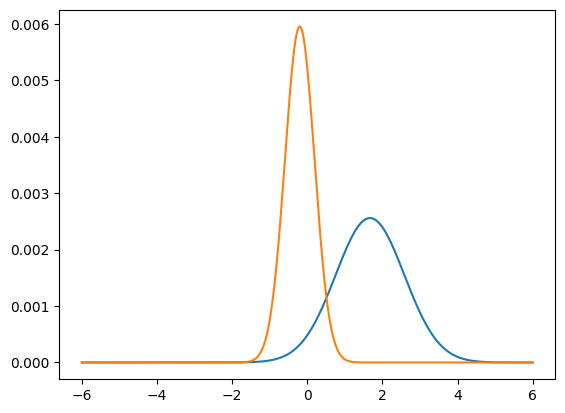

In [91]:
plt.plot(x, mu)
plt.plot(x, nu)

In [97]:
res = PDLPBarycenterSolver().solve(
    marginals=problems[6].get_marginals(),
    costs=problems[6].get_costs(),
    weights=[0.5, 0.5],
    reg=100.0,
    tol=1e-4,
    maxiter=10000
)

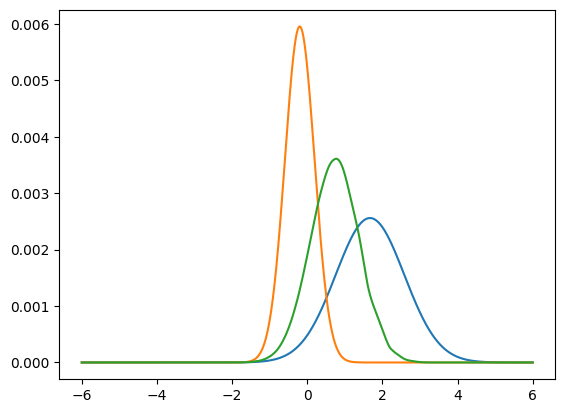

In [98]:
plt.plot(x, mu)
plt.plot(x, nu)
plt.plot(x, res["barycenter"])

In [101]:
res_pot = POTSinkhornBarycenterSolver().solve(
    marginals=problems[6].get_marginals(),
    costs=problems[6].get_costs(),
    weights=[0.5, 0.5],
    reg=0.1,
    tol=1e-4,
    maxiter=10000
)

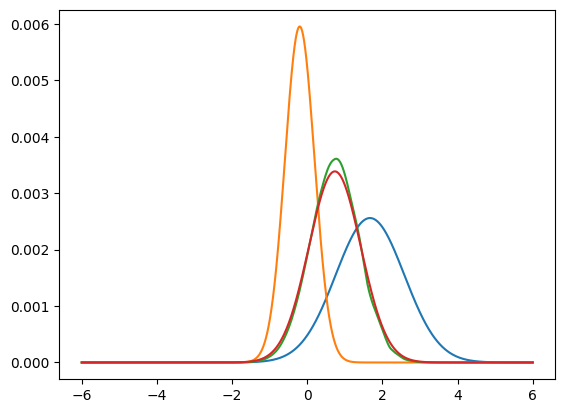

In [102]:
plt.plot(x, mu)
plt.plot(x, nu)
plt.plot(x, res["barycenter"])
plt.plot(x, res_pot["barycenter"])

In [66]:
import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp

_vec = lambda x: jnp.asarray(x).ravel()

def _interp_scalar(x, grid, u):
    """Piecewise‑linear interpolation  u(x)  on irregular grid."""
    grid, u = _vec(grid), _vec(u)
    i  = jnp.clip(jnp.searchsorted(grid, x) - 1, 0, grid.size - 2)
    x0, x1 = grid[i], grid[i + 1]
    t  = (x - x0) / (x1 - x0 + 1e-12)
    return (1 - t) * u[i] + t * u[i + 1]

def _gradient_on_grid(grid, u_vals):
    grad_fn = jax.grad(lambda z: _interp_scalar(z, grid, u_vals))
    return jax.vmap(grad_fn)(grid)

def _linbin(T, w, ref_grid):
    """Linear histogram of (T,w) onto ref_grid; preserves total mass."""
    dx   = ref_grid[1] - ref_grid[0]
    idxf = (T - ref_grid[0]) / dx
    i0   = jnp.clip(jnp.floor(idxf).astype(jnp.int32), 0, ref_grid.size - 2)
    frac = idxf - i0
    out  = jnp.zeros_like(ref_grid)
    out  = out.at[i0    ].add(w * (1 - frac))
    out  = out.at[i0 + 1].add(w * frac)
    return out

# -------------------------------------------------------------------------
def barycenter_from_gradients(
    margs,          # list of (x_i, w_i) arrays  (support & weights)
    u_list,         # list of u_i(x_i) arrays    (potentials on same support)
    ref_grid,       # 1‑D reference grid where barycenter is returned
    weights=None,   # ω_i ; None ⇒ uniform
):
    """
    Compute discrete barycenter ν★ on `ref_grid` via Monge push‑forwards.

    Returns
    -------
    bary_w  : (len(ref_grid),) array  — masses that sum to 1.
    """
    n_marg = len(margs)
    ω = (jnp.ones(n_marg) / n_marg) if weights is None else _vec(weights)/weights.sum()

    ref_grid = _vec(ref_grid)
    bary_w = jnp.zeros_like(ref_grid)

    for (x_i, w_i), u_i, ω_i in zip(margs, u_list, ω):
        x_i, w_i, u_i = map(_vec, (x_i, w_i, u_i))
        grad_i = _gradient_on_grid(x_i, u_i)
        T_i    = x_i - grad_i                       # Monge map
        push_w = _linbin(T_i, w_i, ref_grid)        # mass on ref grid
        bary_w = bary_w + ω_i * push_w

    return bary_w / bary_w.sum()

In [67]:
bary_w = barycenter_from_gradients(
    margs      = [marg.to_discrete() for marg in problems[6].get_marginals()],
    u_list     = res["vs_final"],      # aligned with margs
    ref_grid   = x, # your display / compute grid
    weights    = jnp.array([0.5, 0.5])                        # or e.g. jnp.array([0.2,0.8])
)

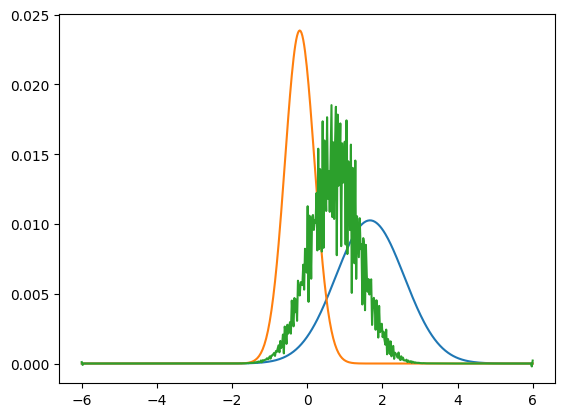

In [68]:
plt.plot(x, mu)
plt.plot(x, nu)
plt.plot(x, bary_w)

In [69]:
def barycenter_from_plans(plans, weights=None):
    w = np.ones(len(plans)) / len(plans) if weights is None else weights/weights.sum()
    a = sum(wi * P.sum(axis=1) for wi, P in zip(w, plans))
    return a / a.sum()

bary_pl = barycenter_from_plans(res["transport_plans"], weights=jnp.array([0.5, 0.5]))

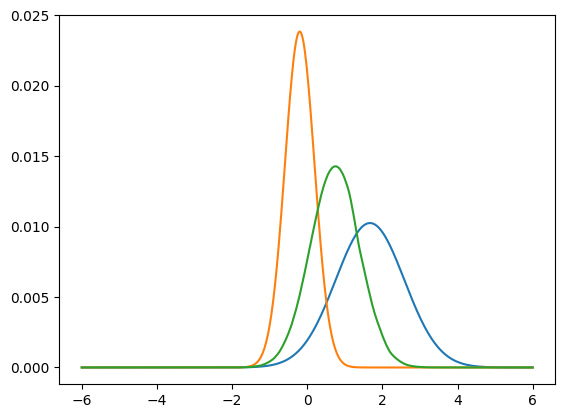

In [70]:
plt.plot(x, mu)
plt.plot(x, nu)
plt.plot(x, bary_pl)

In [109]:
import sys
import os

repo_root = "/home/druban/gpu_tests/ot-algorithm-comparison"
sys.path.insert(0, str(repo_root))

os.environ["CUDA_VISIBLE_DEVICES"] = "3"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.0"

In [25]:
import jax
import logging
from uot.problems.generators.gaussian_mixture_generator import GaussianMixtureGenerator
from uot.solvers.base_solver import BaseSolver
from uot.utils.costs import cost_euclid_squared
from matplotlib import pyplot as plt
from uot.solvers.pdlp import PDLPSolver
from uot.solvers.sinkhorn import SinkhornTwoMarginalSolver
from uot.solvers.gradient_ascent import GradientAscentTwoMarginalSolver
from uot.solvers.ott_sinkhorn import OTTSinkhornSolver
from uot.experiments.experiment import Experiment
from uot.experiments.measurement import measure_time_and_precision, measure_pushforward
from uot.solvers.pdlp_barycenter import PDLPBarycenterSolver
from uot.solvers.pot_barycenter import POTSinkhornBarycenterSolver
from uot.problems.problem_generator import ProblemGenerator

jax.config.update("jax_enable_x64", True)

In [26]:
guassian_generator = GaussianMixtureGenerator(
    name="Gauss1D-64p",
    dim=1,
    num_marginals=2,
    num_components=1,
    n_points=128,
    num_datasets=1,
    weights=[0.5, 0.5],
    borders=[-6, 6],
    cost_fn=cost_euclid_squared,
    use_jax=False
)

In [27]:
problems = guassian_generator.generate_barycenter()
problem = list(problems)[0]

[1.]
[1.]
[1.]
[1.]


In [28]:
margs = problem.get_marginals()
costs = problem.get_costs()

In [141]:
res1 = PDLPBarycenterSolver().solve(marginals=margs, costs=costs, weights=[0.5, 0.5], reg=100.0, maxiter=10000, tol=1e-4)

In [142]:
res2 = POTSinkhornBarycenterSolver().solve(marginals=margs, costs=costs, weights=[0.5, 0.5], reg=1e-1, maxiter=10000, tol=1e-4)

In [6]:
a, b = margs[0].to_discrete()[1], margs[1].to_discrete()[1]

In [8]:
# ──────────────────────────────────────────────────────────────────
#  JAX  log‑Sinkhorn  Barycenter  (marginal‑gap stopping rule)
# ──────────────────────────────────────────────────────────────────
import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
from typing import Tuple, List, Sequence

Array = jnp.ndarray


# ---------- tiny helpers -------------------------------------------------
@jax.jit
def _logmatvec(logK: Array, log_v: Array, rowsum: bool = True) -> Array:
    """rowsum=True → log(K v) ;  rowsum=False → log(Kᵀ u)."""
    Kpart = jax.lax.cond(rowsum, lambda x: x, lambda x: x.T, logK)
    return logsumexp(Kpart + log_v[None, :], axis=1)


@jax.jit
def _marginal_error(
    log_u: Array, log_v: Array,               # (m,n) each
    logK: Array,
    log_a_bar: Array,                         # (n,)
    log_ai: Array,                            # (m,n)
) -> float:
    """max{  ‖row_marg_i−a_bar‖ , ‖col_marg_i−a_i‖ }  across i."""
    m, n = log_u.shape
    K = jnp.exp(logK)                         # (n,n)  only here

    def one_error(lu, lv, log_ai_row):
        row_marg = jnp.exp(lu) * (K @ jnp.exp(lv))
        col_marg = jnp.exp(lv) * (K.T @ jnp.exp(lu))
        err_row  = jnp.linalg.norm(row_marg - jnp.exp(log_a_bar))
        err_col  = jnp.linalg.norm(col_marg - jnp.exp(log_ai_row))
        return jnp.maximum(err_row, err_col)

    errs = jax.vmap(one_error)(log_u, log_v, log_ai)
    return jnp.max(errs)


@jax.jit
def plan_from_potentials(
    f: Array, g: Array, logK: Array, eps: float
) -> Array:
    """Γ = diag(exp(f/ε)) · exp(logK) · diag(exp(g/ε))"""
    return jnp.exp((f[:, None] + g[None, :] + logK * eps) / eps)
# ------------------------------------------------------------------------


@jax.jit
def sinkhorn_barycenter_log(
    C: Array,                 # (n,n) cost on common grid
    hists: Array,             # (n,m) columns = a_i
    reg: float = 1e-2,
    weights: Sequence[float] | None = None,
    max_iters: int = 10_000,
    tol: float = 1e-9,
    check_every: int = 10,    # error frequency (iters)
) -> Tuple[
        Array,                      # a_bar
        List[Tuple[Array, Array]],  # potentials [(f_i,g_i),…]
        List[Array] | None,         # plans [Γ_i,…]  or None
    ]:

    eps = reg
    n, m = hists.shape
    w = (
        jnp.ones(m) / m
        if weights is None
        else jnp.asarray(weights) / jnp.sum(weights)
    )

    # safeguard against log(0)
    # hists / jnp.sum(hists, axis=0, keepdims=True)
    log_ai = jnp.log(hists.T)                  # (m,n)

    logK = -C / eps                            # (n,n)  kernel in log
    log_u = jnp.zeros((m, n))                  # log‑scalings
    log_v = jnp.zeros_like(log_u)
    log_a = jnp.full(n, -jnp.log(n))           # uniform start

    # ---------- while‑loop ------------------------------------------------
    def body_fn(carry):
        log_u, log_v, log_a, i, err = carry

        # 1. update u
        log_Kv = jax.vmap(lambda lv: _logmatvec(logK, lv, rowsum=True))(log_v)
        log_u  = log_a[None, :] - log_Kv

        # 2. update v
        log_KTu = jax.vmap(lambda lu: _logmatvec(logK, lu, rowsum=False))(log_u)
        log_v   = log_ai - log_KTu

        # 3. new barycenter (geo. mean of Kᵀ u_i)
        log_a_new = jnp.sum(w[:, None] * log_KTu, axis=0)
        log_a_new = log_a_new - logsumexp(log_a_new)

        # 4. error every `check_every` iterations
        err_new = jax.lax.cond(
            (i % check_every) == 0,
            lambda: _marginal_error(log_u, log_v, logK, log_a_new, log_ai),
            lambda: err,
        )

        return (log_u, log_v, log_a_new, i + 1, err_new)

    def cond_fn(carry):
        *_rest, i, err = carry
        return jnp.logical_and(err > tol, i < max_iters)

    init_state = (log_u, log_v, log_a, jnp.array(0), jnp.array(jnp.inf))
    log_u, log_v, log_a, iters, err = jax.lax.while_loop(cond_fn, body_fn, init_state)

    # ---------- outputs ---------------------------------------------------
    a_bar = jnp.exp(log_a)

    potentials = [
        (eps * log_u[i], eps * log_v[i]) for i in range(m)
    ]


    plans = [
        plan_from_potentials(pf, pg, logK, eps)
        for pf, pg in potentials
    ]

    return a_bar, potentials, plans, err

In [9]:
A = jnp.stack([
    a, b
], axis=1)
A.shape

(128, 2)

In [114]:
import jax.numpy as jnp, ot

# grid & cost
x = jnp.linspace(-3, 3, 200)
C = costs[0]

# three Gaussian marginals
A = jnp.stack([
    a, b
], axis=1)

C_scaled = C / C.max() * 1e-3

a_bar, potentials, plans, err = sinkhorn_barycenter_log(
    C_scaled, A, reg=1e-5, tol=1e-8
)

print("barycenter mass check:", a_bar.sum())      # ≈ 1.0
print("Γ₀ shape:", plans[0].shape)
print("f₀ shape :", potentials[0][0].shape)
print(err)

barycenter mass check: 0.9999999999999991
Γ₀ shape: (128, 128)
f₀ shape : (128,)
5.261141590679266e-11


In [115]:
a_bar

Array([7.96596676e-02, 7.98356151e-02, 7.90388985e-02, 7.72988319e-02,
       7.46783520e-02, 7.12702395e-02, 6.71916700e-02, 6.25775377e-02,
       5.75730836e-02, 5.23263858e-02, 4.69812466e-02, 4.16709390e-02,
       3.65131651e-02, 3.16064486e-02, 2.70280439e-02, 2.28333167e-02,
       1.90564381e-02, 1.57121559e-02, 1.27983578e-02, 1.02991252e-02,
       8.18799153e-03, 6.43115305e-03, 4.99043392e-03, 3.82586383e-03,
       2.89778607e-03, 2.16846678e-03, 1.60321976e-03, 1.17109338e-03,
       8.45186812e-04, 6.02672439e-04, 4.24602249e-04, 2.95570234e-04,
       2.03292739e-04, 1.38156507e-04, 9.27715689e-05, 6.15543215e-05,
       4.03560412e-05, 2.61439654e-05, 1.67360928e-05, 1.05867708e-05,
       6.61770160e-06, 4.08783000e-06, 2.49533309e-06, 1.50529878e-06,
       8.97396116e-07, 5.28715628e-07, 3.07854993e-07, 1.77160291e-07,
       1.00761165e-07, 5.66418658e-08, 3.14710296e-08, 1.72832478e-08,
       9.38195380e-09, 5.03416962e-09, 2.67019338e-09, 1.40007796e-09,
      

In [122]:
import ot
import numpy as np

def barycenter_with_plans(A, M, reg, weights=None, iters=10000):
    """Return barycenter, list of plans, list of (u,v)."""
    a_bar = ot.bregman.barycenter(A, M, reg, weights, numItermax=iters)
    plans, pots = [], []
    for ai in A.T:
        G, log = ot.bregman.sinkhorn(a_bar, ai, M, reg, log=True)
        plans.append(G)
        pots.append((log['u'], log['v']))
    return a_bar, plans, pots

In [126]:
a_bar, plans, pots = barycenter_with_plans(A, C, reg=1e-2, weights=[0.5, 0.5])

/home/druban/miniconda3/envs/py311/lib/python3.11/site-packages/ot/bregman/_barycenter.py:250: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
/home/druban/miniconda3/envs/py311/lib/python3.11/site-packages/ot/bregman/_sinkhorn.py:643: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn("Warning: numerical errors at iteration %d" % ii)


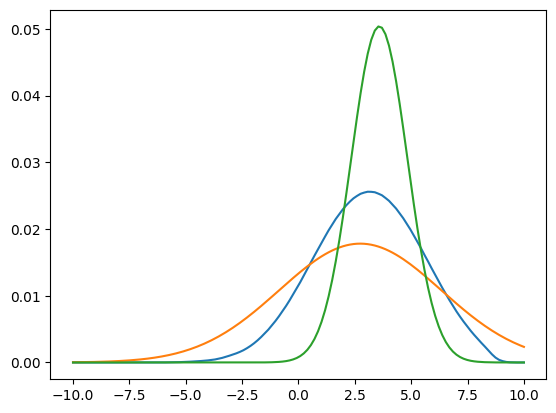

In [145]:
from matplotlib import pyplot as plt

x = jnp.linspace(-10, 10, 128)

plt.plot(x, res1['barycenter'])
# plt.plot(x, a_bar)
plt.plot(x, a)
plt.plot(x, b)


In [131]:
import ot
def barycenter_with_plans(A, M, reg, weights=None, tol=1e-9, numItermax=10_000):
    # 1. barycenter with log tracking
    a_bar, log_bar = ot.bregman.barycenter(
        A, M, reg, weights,
        log=True, stopThr=tol, numItermax=numItermax
    )
    n_iter = log_bar.get("niter", log_bar.get("it", -1))
    # 2. plans & potentials
    plans, pots, marg_err = [], [], 0.0
    for ai in A.T:
        G, log = ot.bregman.sinkhorn(
            a_bar, ai, M, reg, log=True, stopThr=tol
        )
        plans.append(G)
        pots.append((log["u"], log["v"]))

        # update marginal error
        row_err = jnp.linalg.norm(G.sum(axis=1) - a_bar, 1)
        col_err = jnp.linalg.norm(G.sum(axis=0) - ai, 1)
        marg_err = max(marg_err, float(max(row_err, col_err)))

    return a_bar, plans, pots, marg_err, int(n_iter)

In [134]:
a_bar, plans, pots, marg_err, n_iter = barycenter_with_plans(A, C, reg=1e-1, weights=[0.5, 0.5])

finish bary


In [139]:
len(pots[0])

2

In [18]:
import numpy as np

def gm_barycenter_1d(
    margs,
    marg_weights: np.ndarray | None = None,   # (n_marginals,), optional
):
    means = [margs[0].means[0], margs[1].means[0]] if margs[0].means.shape == (1, 1) else jnp.array([
        margs[0].means, margs[1].means
    ]).reshape(2, 2)
    sigmas = [
        jnp.sqrt(margs[0].covs[0][0]), jnp.sqrt(margs[1].covs[0][0])
    ] if margs[0].covs.shape == (1, 1, 1) else [
        jnp.sqrt(margs[0].covs), jnp.sqrt(margs[1].covs)
    ]
    mix_weights = [margs[0].comp_weights, margs[1].comp_weights]

    print(mix_weights)
    means   = np.asarray(means,  dtype=float)
    sigmas  = np.asarray(sigmas, dtype=float)
    weights = np.asarray(mix_weights, dtype=float)
    print(means.shape, sigmas.shape, weights.shape)
    marg_weights = np.asarray(marg_weights, dtype=float)
    marg_weights = marg_weights / marg_weights.sum()

    if means.shape != sigmas.shape or means.shape != weights.shape:
        raise ValueError("means, sigmas, mix_weights must share the same shape")

    # barycenter mixture weights  π̄_j
    bar_mix = (marg_weights[:, None] * weights).sum(axis=0)
    bar_mix = bar_mix / bar_mix.sum()        # ensure ∑π̄ = 1

    # component‑wise Gaussian barycenters
    bar_means  = (marg_weights[:, None] * means).sum(axis=0)
    bar_sigmas = (marg_weights[:, None] * sigmas).sum(axis=0)
    print(sigmas)
    bar_vars   = bar_sigmas ** 2

    return bar_means, bar_sigmas, bar_mix

In [10]:
# 3 marginals, each with 2 Gaussian components
means  = [[-2,  3],
          [-1,  4],
          [-3,  2]]
sigmas = [[1.0, 0.5],
          [0.8, 0.6],
          [1.2, 0.4]]
mix_w  = [[0.4, 0.6],
          [0.5, 0.5],
          [0.3, 0.7]]
marg_w = [0.2, 0.5, 0.3]

m̄, σ̄, σ̄2, π̄ = gm_barycenter_1d(means, sigmas, mix_w, marg_w)
print("means* :", m̄)
print("sigmas*:", σ̄)
print("weights:", π̄)

means* : [-1.8  3.2]
sigmas*: [0.96 0.52]
weights: [0.42 0.58]


In [156]:
(x, a), (_, b) = margs[0].to_discrete(), margs[1].to_discrete()

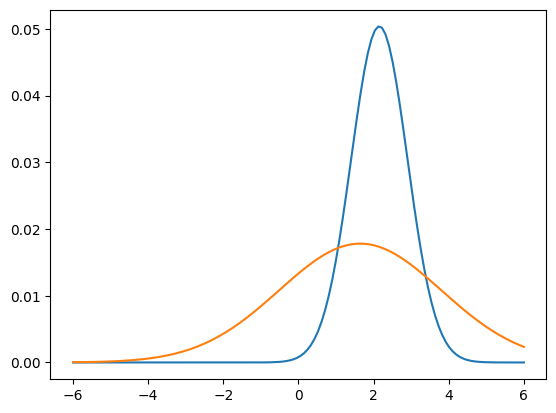

In [157]:
plt.plot(x, b)
plt.plot(x, a)

In [19]:
means = [margs[0].means[0], margs[1].means[0]]
# sigmas = [jnp.sqrt(margs[0].covs[0][0]), jnp.sqrt(margs[1].covs[0][0])]
mix_w = [[1], [1]]
marg_w = [0.5, 0.5]
bar_means, bar_sigmas, bar_mix = gm_barycenter_1d(margs, marg_w)

[array([1.]), array([1.])]
(2, 1) (2, 1) (2, 1)
[[2.16156872]
 [0.74805654]]


In [8]:
from jax import numpy as jnp

def gm_pdf(x, means, sigmas, weights=None):
    means  = jnp.asarray(means,  dtype=float)
    sigmas = jnp.asarray(sigmas, dtype=float)
    if weights is None:
        weights = jnp.ones_like(means) / means.size
    else:
        weights = jnp.asarray(weights, dtype=float)
        weights = weights / weights.sum()

    x = jnp.asarray(x, dtype=float)[..., None]          # broadcast over comps
    z = (x - means) / sigmas
    comp_pdf = jnp.exp(-0.5 * z**2) / (sigmas * jnp.sqrt(2.0 * jnp.pi))
    return jnp.sum(weights * comp_pdf, axis=-1)

In [165]:
nu_star = gm_pdf(x, bar_means, bar_sigmas)
nu_star /= nu_star.sum()
print(b.std(), bar_means)

0.014742408084176591 [1.89766191]


In [166]:
a /= a.sum()
b /= b.sum()

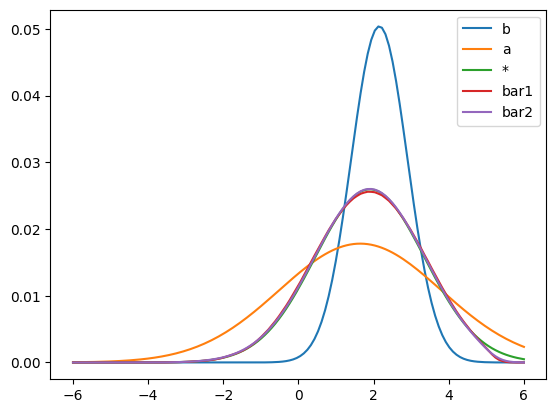

In [167]:
plt.plot(x, b, label="b")
plt.plot(x, a, label="a")
plt.plot(x, nu_star, label="*")
plt.plot(x, res1['barycenter'], label="bar1")
plt.plot(x, res2['barycenter'], label="bar2")
plt.legend()
plt.show()

In [120]:
print(margs[0].means[0], bar_means, margs[1].means[0])
print([margs[0].covs[0][0], bar_sigmas, margs[1].covs[0][0]])

[1.64373629] [1.89766191] [2.15158752]
[array([4.67237931]), array([2.61598395]), array([0.55958858])]


In [101]:
# 1️⃣  grid
x = jnp.linspace(-10.0, 10.0, 400)   # 400 points, uniform

# 2️⃣  parameters
mu_1,  sigma_1 = -5.0,  jnp.sqrt(0.1)   # variance 0.1 ⇒ σ ≈ 0.316
mu_2,  sigma_2 =  5.0,  jnp.sqrt(0.3)   # variance 0.3 ⇒ σ ≈ 0.548

# 3️⃣  Gaussian pdf helper
def normal_pdf(x, mu, sigma):
    z = (x - mu) / sigma
    return jnp.exp(-0.5 * z**2) / (sigma * jnp.sqrt(2.0 * jnp.pi))

g1 = normal_pdf(x, mu_1, sigma_1)   # first Gaussian
g2 = normal_pdf(x, mu_2, sigma_2)   # second Gaussian
g1 /= g1.sum()
g2 /= g2.sum()

In [104]:
means = [
    [-5.0], [5.0]
]
covs = [
    [jnp.sqrt(0.1)], [jnp.sqrt(0.3)]
]
mix_w = [[1], [1]]
marg_w = [0.5, 0.5]
bar_means, bar_sigmas, bar_mix = gm_barycenter_1d(means, covs, mix_w, marg_w)

(2, 1) (2, 1) (2, 1)
(2,)
[[0.31622777]
 [0.54772256]]


In [105]:
bar_sigmas

array([0.43197516])

In [106]:
nu_star = gm_pdf(x, bar_means, bar_sigmas, bar_mix)
nu_star = nu_star / nu_star.sum()

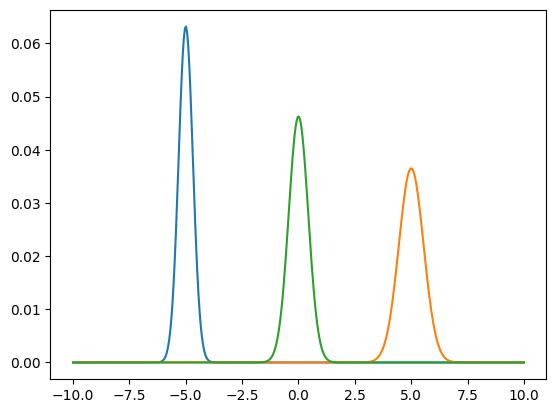

In [107]:
plt.plot(x, g1)
plt.plot(x, g2)
plt.plot(x, nu_star)

In [107]:
import requests, pathlib, hashlib, tqdm, sys

# ------------ pick the split you want -----------------
# by_class  : ~ 236 MB, characters grouped 0–9, A–Z, a–z
# by_write  : ~ 527 MB, grouped by writer id (handwriting forms)
# by_merge  : ~ 387 MB, digits + upper/lower merged
ZIP_URL = "https://s3.amazonaws.com/nist-srd/SD19/by_class.zip"   # ← change if needed
DEST    = pathlib.Path("/home/druban/gpu_tests/ot-algorithm-comparison/sd19_by_class.zip")     # where to save

# ------------ download with progress bar -------------
resp = requests.get(ZIP_URL, stream=True, timeout=30)
resp.raise_for_status()
total = int(resp.headers.get("content-length", 0))
with DEST.open("wb") as f, tqdm.tqdm(total=total, unit="B", unit_scale=True) as bar:
    for chunk in resp.iter_content(chunk_size=8192):
        f.write(chunk)
        bar.update(len(chunk))

# ------------ (optional) quick MD5 check -------------
def md5(path):
    h = hashlib.md5()
    with path.open("rb") as fp:
        for blk in iter(lambda: fp.read(1 << 20), b""):
            h.update(blk)
    return h.hexdigest()

print("MD5:", md5(DEST))

100%|██████████| 1.03G/1.03G [00:26<00:00, 39.6MB/s]


MD5: 79572b1694a8506f2b722c7be54130c4


In [ ]:
import  zipfile
OUT_DIR = DEST.with_suffix("")
with zipfile.ZipFile(DEST, "r") as zf:
    zf.extractall(OUT_DIR)
print("Extracted to:", OUT_DIR)

In [106]:
from pathlib import Path
import random, matplotlib.pyplot as plt
from PIL import Image

# 1️⃣  path to your extracted SD‑19 “4” folder
four_dir = Path("by_class/4")          # adjust if you unpacked elsewhere

# 2️⃣  pick any two different images
all_fours = sorted(four_dir.glob("*.png"))          # or *.tif if not converted
samples   = random.sample(all_fours, 2)

# 3️⃣  load + display
fig, axs = plt.subplots(1, 2, figsize=(4, 2))
for ax, fp in zip(axs, samples):
    ax.imshow(Image.open(fp), cmap="gray")
    ax.set_title(fp.name)
    ax.axis("off")
plt.tight_layout()
plt.show()

0


ValueError: Sample larger than population or is negative